In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";   

#### Example of text classification with BERT.

Reference pages:
- https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

Loading balanced dataset.

In [2]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
print(df.isnull().sum())
df.head()

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


Spliting test and train sets.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

text = df.Consumer_complaint_narrative
label = df.Product

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, label):
    train_sentences = text.loc[train_index].tolist()
    Y_train = label.loc[train_index].tolist()
    test_sentences = text.loc[test_index].tolist()
    Y_test = label.loc[test_index].tolist()

Preprocessing data.

In [12]:
import ktrain
from ktrain import text
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [13]:
%%time

MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, 
                     maxlen=150)
trn = t.preprocess_train(train_sentences, 
                         Y_train)
val = t.preprocess_test(test_sentences, 
                        Y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 223
	95percentile : 671
	99percentile : 1286


preprocessing test...
language: en
test sequence lengths:
	mean : 235
	95percentile : 702
	99percentile : 1291


CPU times: user 26.8 s, sys: 87.2 ms, total: 26.9 s
Wall time: 27.2 s


**Model**

In [14]:
model = t.get_classifier()
learner = ktrain.get_learner(model, 
                             train_data=trn, 
                             val_data=val, 
                             batch_size=6)

Estimating learning rate.

simulating training for different learning rates... this may take a few moments...
Train for 419 steps
Epoch 1/3
419/419 [==============================] - 1317s 3s/step - loss: 1.4728 - accuracy: 0.3373
Epoch 2/3
419/419 [==============================] - 1299s 3s/step - loss: 1.4594 - accuracy: 0.3331
Epoch 3/3
355/419 [========================>.....] - ETA: 3:17 - loss: 2.4684 - accuracy: 0.2013

done.
Visually inspect loss plot and select learning rate associated with falling loss


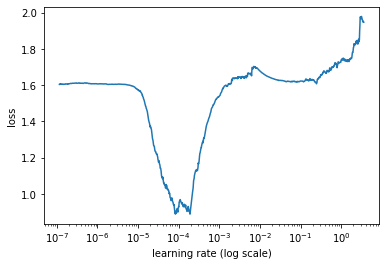

In [15]:
%time
learner.lr_find(show_plot=True, 
                max_epochs=2)

Training the model.

In [16]:
%%time
learner.fit_onecycle(8e-5, 
                     2)



begin training using onecycle policy with max lr of 8e-05...
Train for 420 steps, validate for 34 steps
Epoch 1/2
420/420 [==============================] - 1483s 4s/step - loss: 1.0440 - accuracy: 0.6041 - val_loss: 0.6999 - val_accuracy: 0.7674
Epoch 2/2
420/420 [==============================] - 1455s 3s/step - loss: 0.5009 - accuracy: 0.8382 - val_loss: 0.4377 - val_accuracy: 0.8582
CPU times: user 2h 59min 25s, sys: 5min 57s, total: 3h 5min 22s
Wall time: 48min 57s


Evaluation.

In [17]:
%%time

learner.validate(class_names=t.get_classes())

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.89      0.89      0.89       216
                                                 Credit card or prepaid card       0.82      0.83      0.82       216
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.83      0.84       215
                                                             Debt collection       0.81      0.81      0.81       216
                                                                    Mortgage       0.91      0.93      0.92       216

                                                                    accuracy                           0.86      1079
                                                                   macro avg       0.86      0.86      0.86      1079
                                                      

array([[193,  16,   2,   2,   3],
       [ 17, 179,   4,  12,   4],
       [  0,  12, 179,  22,   2],
       [  3,   8,  21, 174,  10],
       [  4,   3,   4,   4, 201]])